**Problem**: Explore market data distributions in different formats.

- Time Bars
- Tick Bars
- Volume Bars
- Dollar Bars

**Data:** BTC trade tick information for one day

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [91]:
trades = pd.read_csv('BTC.txt', header=None)

In [92]:
used_columns = ['Time', 'Price', 'Volume', 'Exchange']
trades.rename(columns={k:v for k, v in zip(list(range(4)), used_columns)}, inplace=True)

In [95]:
# takes data only from one exchange
trades = trades.loc[trades.Exchange == 4]
trades.head()

,Time,Price,Volume,Exchange
0,2021-02-04 00:00:00:266,37623.92,0.04597,4
2,2021-02-04 00:00:00:535,37618.20,16.03296,4
29,2021-02-04 00:00:03:507,37624.02,11.92151,4
40,2021-02-04 00:00:06:434,37623.97,0.01331,4
45,2021-02-04 00:00:07:057,37625.13,3.08222,4


In [99]:
f = lambda x: x + '000' # ms to us
trades.Time = trades.Time.apply(f)

In [108]:
trades.Time = pd.to_datetime(trades.Time, errors='coerce', format='%Y-%m-%d %H:%M:%S:%f')
trades.set_index('Time', inplace=True)

In [109]:
trades.head()

,Price,Volume,Exchange
Time,,,
2021-02-04 00:00:00.266,37623.92,0.04597,4
2021-02-04 00:00:00.535,37618.20,16.03296,4
2021-02-04 00:00:03.507,37624.02,11.92151,4
2021-02-04 00:00:06.434,37623.97,0.01331,4
2021-02-04 00:00:07.057,37625.13,3.08222,4


<AxesSubplot:xlabel='Time'>

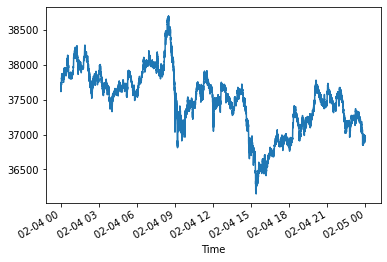

In [110]:
trades.Price.plot()

# 1. Time bars

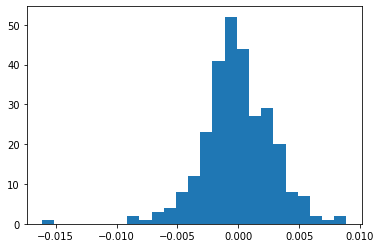

In [112]:
# Takes 5 mins intervals
time_bars = trades.groupby(pd.Grouper(freq='5min')).agg({'Price': 'ohlc', 'Volume': 'sum'})
time_bars_price = time_bars.loc[:, 'Price']
time_bars_price
time_bars = np.log(time_bars_price.close/time_bars_price.close.shift(1)).dropna()
bin_len = 0.001
plt.hist(time_bars, bins=np.arange(min(time_bars),max(time_bars)+bin_len, bin_len))
plt.show()

What are the Issues?
- oversampling information from low activity periods
- undersampling information from high-activity periods
- Time sampled data often have poor statistical properties (Easley, Lopez de Prado, and O’Hara [2011]):    
- serial correlation: correlation of data with a delayed copy of itself (lag)     
- heteroschedasticity: variance (residual term variation/error) changes over time    
- nonnormality of returns 

This can cause issues in analysis: 
- Autocorrelation can cause problems in conventional analyses (such as ordinary least squares regression) that assume independence of observations. 
- Heteroscedasticity is a problem because ordinary least squares (OLS) regression assumes that all residuals are drawn from a population that has a constant variance (homoscedasticity). 
GARCH models were developed to deal with heteroschedasticity. By sampling price and volume information as a subordinated process of trading activity we can avoid this problem to begin with.

# 2. Tick Bars

In [115]:
# Helper bar function to construct / return a integer number of bars
def bar(x, y):
    return np.int64(x/y)*y

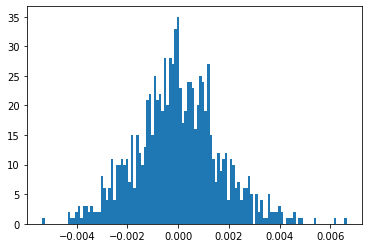

In [119]:
transactions = 75 # For example, Open, High, Low, Close and Volume are sampled over 75 transactions

tick_bars = trades.groupby(bar(np.arange(len(trades)), transactions)).agg({'Price': 'ohlc', 'Volume': 'sum'})
tick_bars_price = tick_bars.loc[:, 'Price']
tick_bars = np.log(tick_bars_price.close/tick_bars_price.close.shift(1)).dropna()
bin_len = 0.0001
plt.hist(tick_bars, bins=np.arange(min(tick_bars),max(tick_bars)+bin_len, bin_len))
plt.show()

# 3. Volume Bars

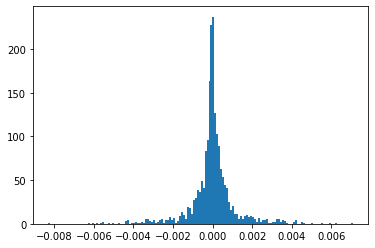

In [124]:
# Volume bars are sampled every time a pre-defined amount the the security’s units have been exchanged
traded_volume = 10

volume_bars = trades.groupby(bar(np.cumsum(trades['Volume']), traded_volume)).agg({'Price': 'ohlc', 'Volume': 'sum'})
volume_bars_price = volume_bars.loc[:,'Price']

volume_bars = np.log(volume_bars_price.close/volume_bars_price.close.shift(1)).dropna()
bin_len = 0.0001
plt.hist(volume_bars, bins=np.arange(min(volume_bars),max(volume_bars)+bin_len, bin_len))
plt.show()

# 4. Dollar Bars

In [137]:
trades['Value'] = trades.apply(lambda row: row.Price * row.Volume, axis=1)

In [138]:
trades.head()

,Price,Volume,Exchange,Value
Time,,,,
2021-02-04 00:00:00.266,37623.92,0.04597,4,1729.571602
2021-02-04 00:00:00.535,37618.20,16.03296,4,603131.095872
2021-02-04 00:00:03.507,37624.02,11.92151,4,448535.130670
2021-02-04 00:00:06.434,37623.97,0.01331,4,500.775041
2021-02-04 00:00:07.057,37625.13,3.08222,4,115968.928189


In [140]:
trades.describe()

,Price,Volume,Exchange,Value
count,71816.000000,71816.000000,71816.0,7.181600e+04
mean,37466.865238,0.372199,4.0,1.394987e+04
std,474.313014,2.284762,0.0,8.567468e+04
min,36147.430000,0.000010,4.0,3.614934e-01
25%,37160.375000,0.000790,4.0,2.962176e+01
50%,37491.140000,0.007530,4.0,2.824842e+02
75%,37786.680000,0.036830,4.0,1.377197e+03
max,38706.000000,36.876420,4.0,1.368779e+06


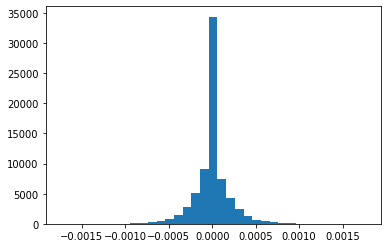

In [141]:
# Dollar bars are formed by sampling an observation every time a pre-defined market value is exchanged
market_value = 0.37

dollar_bars = trades.groupby(bar(np.cumsum(trades['Value']), market_value)).agg({'Price': 'ohlc', 'Volume':'sum'})
dollar_bars_price = dollar_bars.loc[:,'Price']

dollar_bars = np.log(dollar_bars_price.close/dollar_bars_price.close.shift(1)).dropna()
bin_len = 0.0001
plt.hist(dollar_bars, bins=np.arange(min(dollar_bars),max(dollar_bars)+bin_len, bin_len))
plt.show()

# Plot distributions

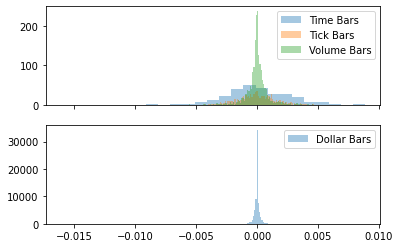

In [201]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
cdmx_edad = np.random.normal(0, 20,10000)+10
ed_sup_edad = dollar_bars
dollar_bars = np.log(dollar_bars_price.close/dollar_bars_price.close.shift(1)).dropna()
volume_bars = np.log(volume_bars_price.close/volume_bars_price.close.shift(1)).dropna()
tick_bars = np.log(tick_bars_price.close/tick_bars_price.close.shift(1)).dropna()
time_bars = np.log(time_bars_price.close/time_bars_price.close.shift(1)).dropna()


fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
bin_len = 0.001
ax1.hist(time_bars, bins=np.arange(min(time_bars),max(time_bars)+bin_len, bin_len),alpha=0.4, label='Time Bars')
bin_len = 0.0001
ax1.hist(tick_bars, bins=np.arange(min(tick_bars),max(tick_bars)+bin_len, bin_len),alpha=0.4, label='Tick Bars')
ax1.hist(volume_bars, bins=np.arange(min(volume_bars),max(volume_bars)+bin_len, bin_len),alpha=0.4, label='Volume Bars')
ax1.legend()


ax2.hist(dollar_bars, bins=np.arange(min(dollar_bars),max(dollar_bars)+bin_len, bin_len),alpha=0.4, label='Dollar Bars')
ax2.legend()